# Training a CNN model for Object Recognition


We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [1]:
# ---------------------------------------------------------------------------- #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 20
learning_rate = 0.001
batch_size = 100

## Load CIFAR10 Dataset

In [3]:
# Image preprocessing modules
transform = transforms.Compose([transforms.Pad(4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32),
                                transforms.ToTensor()])


# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Display some of the training images

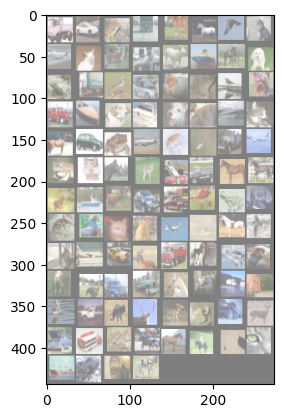

truck   car  frog truck horse horse  bird   dog plane   cat  deer   car   dog  ship horse   dog  frog truck  bird   car  bird  frog  bird   dog truck  ship   dog  ship   dog   cat  ship   cat horse   car  frog plane  bird  bird truck plane  frog   cat horse  deer truck   car horse horse  deer  ship  deer   car   car plane  frog   dog  frog  bird   cat   cat plane  ship horse  bird  deer plane   car  deer truck   dog plane   dog   dog  bird truck truck horse  bird truck truck  bird truck  bird  deer  deer  frog   car  deer   car truck  frog horse horse horse   cat   cat  ship  frog   cat horse


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
# images, labels = dataiter.next() 
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Define a Convolutional Neural Network

In [7]:
# This script works with two CNN models 
# model_name = 'ResNet'
# model_name = 'Simple_CNN'

model_name = 'Simple_CNN'             

In [4]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
class Simple_CNN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
### Residual Network

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
if model_name == 'Simple_CNN':
    model = Simple_CNN().to(device)
else:
    model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

## Define a Loss function, optimizer and learning rate shedular

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Train the network

In [49]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/20], Step [100/500] Loss: 0.7594
Epoch [1/20], Step [200/500] Loss: 0.9556
Epoch [1/20], Step [300/500] Loss: 0.7209
Epoch [1/20], Step [400/500] Loss: 0.7686
Epoch [1/20], Step [500/500] Loss: 0.8635
Epoch [2/20], Step [100/500] Loss: 0.6643
Epoch [2/20], Step [200/500] Loss: 0.7249
Epoch [2/20], Step [300/500] Loss: 0.6277
Epoch [2/20], Step [400/500] Loss: 0.8777
Epoch [2/20], Step [500/500] Loss: 0.8407
Epoch [3/20], Step [100/500] Loss: 0.6236
Epoch [3/20], Step [200/500] Loss: 0.6703
Epoch [3/20], Step [300/500] Loss: 0.7307
Epoch [3/20], Step [400/500] Loss: 0.7163
Epoch [3/20], Step [500/500] Loss: 0.7537
Epoch [4/20], Step [100/500] Loss: 0.7627
Epoch [4/20], Step [200/500] Loss: 0.4205
Epoch [4/20], Step [300/500] Loss: 0.7097
Epoch [4/20], Step [400/500] Loss: 0.9345
Epoch [4/20], Step [500/500] Loss: 0.9044
Epoch [5/20], Step [100/500] Loss: 0.7561
Epoch [5/20], Step [200/500] Loss: 0.6517
Epoch [5/20], Step [300/500] Loss: 0.6050
Epoch [5/20], Step [400/500] Loss:

## Test the network on the test data

In [62]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), model_name + '.ckpt')

Accuracy of the model on the test images: 78.49 %


In [61]:
if model_name == 'Simple_CNN':
    model = Simple_CNN().to(device)
else:
    model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

PATH = './' + model_name + '.ckpt'
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [63]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 77.0 %
Accuracy for class car   is: 90.4 %
Accuracy for class bird  is: 66.3 %
Accuracy for class cat   is: 56.5 %
Accuracy for class deer  is: 77.2 %
Accuracy for class dog   is: 76.2 %
Accuracy for class frog  is: 87.4 %
Accuracy for class horse is: 76.8 %
Accuracy for class ship  is: 87.9 %
Accuracy for class truck is: 89.2 %


## Test Simple CNN with BatchNormalization

In [65]:
# Load and test Simple_CNN_BN model
model_bn = Simple_CNN_BN().to(device)
PATH_BN = './Simple_CNN_BN.ckpt'
model_bn.load_state_dict(torch.load(PATH_BN))

model_bn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_bn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of Simple_CNN_BN on the test images: {} %'.format(100 * correct / total))

Accuracy of Simple_CNN_BN on the test images: 10.57 %


In [66]:
# Train Simple_CNN_BN from scratch
model_bn = Simple_CNN_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
print("Training Simple_CNN with BatchNormalization...")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_bn(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Training Simple_CNN with BatchNormalization...
Epoch [1/20], Step [100/500] Loss: 1.5857
Epoch [1/20], Step [200/500] Loss: 1.4635
Epoch [1/20], Step [300/500] Loss: 1.3988
Epoch [1/20], Step [400/500] Loss: 1.2155
Epoch [1/20], Step [500/500] Loss: 1.3717
Epoch [2/20], Step [100/500] Loss: 1.0853
Epoch [2/20], Step [200/500] Loss: 1.2667
Epoch [2/20], Step [300/500] Loss: 1.2024
Epoch [2/20], Step [400/500] Loss: 1.1743
Epoch [2/20], Step [500/500] Loss: 1.1674
Epoch [3/20], Step [100/500] Loss: 1.0060
Epoch [3/20], Step [200/500] Loss: 1.1015
Epoch [3/20], Step [300/500] Loss: 0.8827
Epoch [3/20], Step [400/500] Loss: 0.9856
Epoch [3/20], Step [500/500] Loss: 1.0360
Epoch [4/20], Step [100/500] Loss: 0.9056
Epoch [4/20], Step [200/500] Loss: 0.9992
Epoch [4/20], Step [300/500] Loss: 1.1341
Epoch [4/20], Step [400/500] Loss: 0.8337
Epoch [4/20], Step [500/500] Loss: 0.8307
Epoch [5/20], Step [100/500] Loss: 1.2153
Epoch [5/20], Step [200/500] Loss: 1.0189
Epoch [5/20], Step [300/500] 

In [67]:
# Evaluate trained Simple_CNN_BN and save checkpoint
model_bn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_bn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of Simple_CNN_BN on the test images: {} %'.format(100 * correct / total))

torch.save(model_bn.state_dict(), 'Simple_CNN_BN.ckpt')

Accuracy of Simple_CNN_BN on the test images: 72.5 %


## Train Simple CNN with more epochs

In [68]:
# Train Simple_CNN for more epochs (increased from 20)
num_epochs_more = 30
model_simple_more = Simple_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simple_more.parameters(), lr=learning_rate)

print("Training Simple_CNN with more epochs...")
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs_more):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_simple_more(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                epoch+1, num_epochs_more, i+1, total_step, loss.item()))

    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Evaluate
model_simple_more.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_simple_more(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of Simple_CNN with more epochs on the test images: {} %'.format(100 * correct / total))

Training Simple_CNN with more epochs...
Epoch [1/30], Step [100/500] Loss: 2.0957
Epoch [1/30], Step [200/500] Loss: 1.5496
Epoch [1/30], Step [300/500] Loss: 1.4619
Epoch [1/30], Step [400/500] Loss: 1.3786
Epoch [1/30], Step [500/500] Loss: 1.3584
Epoch [2/30], Step [100/500] Loss: 1.5241
Epoch [2/30], Step [200/500] Loss: 1.1259
Epoch [2/30], Step [300/500] Loss: 1.2514
Epoch [2/30], Step [400/500] Loss: 1.3741
Epoch [2/30], Step [500/500] Loss: 1.2040
Epoch [3/30], Step [100/500] Loss: 1.0918
Epoch [3/30], Step [200/500] Loss: 1.0372
Epoch [3/30], Step [300/500] Loss: 1.1781
Epoch [3/30], Step [400/500] Loss: 1.1282
Epoch [3/30], Step [500/500] Loss: 1.2152
Epoch [4/30], Step [100/500] Loss: 1.1135
Epoch [4/30], Step [200/500] Loss: 0.9829
Epoch [4/30], Step [300/500] Loss: 1.0342
Epoch [4/30], Step [400/500] Loss: 1.1157
Epoch [4/30], Step [500/500] Loss: 1.0060
Epoch [5/30], Step [100/500] Loss: 0.8748
Epoch [5/30], Step [200/500] Loss: 0.7689
Epoch [5/30], Step [300/500] Loss: 1

## Task 2: ResNet with residual blocks

In [69]:
# Train ResNet with [2,2,2] blocks for 20 epochs
print("Training ResNet with [2,2,2] blocks (20 epochs)...")
model_resnet_222 = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_222.parameters(), lr=learning_rate)

num_epochs_resnet = 20
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs_resnet):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_resnet_222(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                epoch+1, num_epochs_resnet, i+1, total_step, loss.item()))

    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Evaluate ResNet [2,2,2]
model_resnet_222.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_resnet_222(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy_resnet_222 = 100 * correct / total
    print('Accuracy of ResNet [2,2,2] on the test images: {} %'.format(accuracy_resnet_222))

Training ResNet with [2,2,2] blocks (20 epochs)...
Epoch [1/20], Step [100/500] Loss: 1.6628
Epoch [1/20], Step [200/500] Loss: 1.4478
Epoch [1/20], Step [300/500] Loss: 1.3519
Epoch [1/20], Step [400/500] Loss: 1.1804
Epoch [1/20], Step [500/500] Loss: 1.1421
Epoch [2/20], Step [100/500] Loss: 1.1417
Epoch [2/20], Step [200/500] Loss: 0.8535
Epoch [2/20], Step [300/500] Loss: 0.8282
Epoch [2/20], Step [400/500] Loss: 0.8249
Epoch [2/20], Step [500/500] Loss: 0.9550
Epoch [3/20], Step [100/500] Loss: 1.0053
Epoch [3/20], Step [200/500] Loss: 0.7873
Epoch [3/20], Step [300/500] Loss: 0.8740
Epoch [3/20], Step [400/500] Loss: 0.9725
Epoch [3/20], Step [500/500] Loss: 0.8081
Epoch [4/20], Step [100/500] Loss: 0.7078
Epoch [4/20], Step [200/500] Loss: 0.7863
Epoch [4/20], Step [300/500] Loss: 1.0256
Epoch [4/20], Step [400/500] Loss: 0.9052
Epoch [4/20], Step [500/500] Loss: 0.6508
Epoch [5/20], Step [100/500] Loss: 0.7186
Epoch [5/20], Step [200/500] Loss: 0.5228
Epoch [5/20], Step [300/5

## Task 2.5: ResNet with more residual blocks

In [12]:
# Train ResNet with more blocks [3,3,3]
print("Training ResNet with [3,3,3] blocks (20 epochs)...")
model_resnet_333 = ResNet(ResidualBlock, [3, 3, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_333.parameters(), lr=learning_rate)

num_epochs_resnet_more = 20
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs_resnet_more):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_resnet_333(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                epoch+1, num_epochs_resnet_more, i+1, total_step, loss.item()))

    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Evaluate ResNet [3,3,3]
model_resnet_333.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_resnet_333(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy_resnet_333 = 100 * correct / total
    print('Accuracy of ResNet [3,3,3] on the test images: {} %'.format(accuracy_resnet_333))

Training ResNet with [3,3,3] blocks (20 epochs)...
Epoch [1/20], Step [100/500] Loss: 1.6170
Epoch [1/20], Step [200/500] Loss: 1.4030
Epoch [1/20], Step [300/500] Loss: 1.2715
Epoch [1/20], Step [400/500] Loss: 1.1315
Epoch [1/20], Step [500/500] Loss: 1.0425
Epoch [2/20], Step [100/500] Loss: 1.2379
Epoch [2/20], Step [200/500] Loss: 0.8399
Epoch [2/20], Step [300/500] Loss: 0.9616
Epoch [2/20], Step [400/500] Loss: 1.1007
Epoch [2/20], Step [500/500] Loss: 0.7204
Epoch [3/20], Step [100/500] Loss: 0.6873
Epoch [3/20], Step [200/500] Loss: 1.0658
Epoch [3/20], Step [300/500] Loss: 0.6906
Epoch [3/20], Step [400/500] Loss: 0.8213
Epoch [3/20], Step [500/500] Loss: 0.8114
Epoch [4/20], Step [100/500] Loss: 0.7718
Epoch [4/20], Step [200/500] Loss: 0.9991
Epoch [4/20], Step [300/500] Loss: 0.7256
Epoch [4/20], Step [400/500] Loss: 0.6821
Epoch [4/20], Step [500/500] Loss: 0.5579
Epoch [5/20], Step [100/500] Loss: 0.5417
Epoch [5/20], Step [200/500] Loss: 0.6211
Epoch [5/20], Step [300/5

## Task 2.6: ResNet with more epochs

In [13]:
# Train ResNet [2,2,2] with more epochs (30)
print("Training ResNet [2,2,2] with more epochs (30)...")
model_resnet_222_more = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_222_more.parameters(), lr=learning_rate)

num_epochs_resnet_more_epochs = 30
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs_resnet_more_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_resnet_222_more(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                epoch+1, num_epochs_resnet_more_epochs, i+1, total_step, loss.item()))

    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Evaluate ResNet [2,2,2] with more epochs
model_resnet_222_more.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_resnet_222_more(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy_resnet_222_more = 100 * correct / total
    print('Accuracy of ResNet [2,2,2] (30 epochs) on the test images: {} %'.format(accuracy_resnet_222_more))

Training ResNet [2,2,2] with more epochs (30)...
Epoch [1/30], Step [100/500] Loss: 1.8947
Epoch [1/30], Step [200/500] Loss: 1.4740
Epoch [1/30], Step [300/500] Loss: 1.1770
Epoch [1/30], Step [400/500] Loss: 1.1192
Epoch [1/30], Step [500/500] Loss: 1.2715
Epoch [2/30], Step [100/500] Loss: 0.9459
Epoch [2/30], Step [200/500] Loss: 0.9843
Epoch [2/30], Step [300/500] Loss: 1.0409
Epoch [2/30], Step [400/500] Loss: 0.8796
Epoch [2/30], Step [500/500] Loss: 0.8145
Epoch [3/30], Step [100/500] Loss: 0.7801
Epoch [3/30], Step [200/500] Loss: 0.9357
Epoch [3/30], Step [300/500] Loss: 0.8439
Epoch [3/30], Step [400/500] Loss: 0.7919
Epoch [3/30], Step [500/500] Loss: 0.6866
Epoch [4/30], Step [100/500] Loss: 0.7442
Epoch [4/30], Step [200/500] Loss: 0.9136
Epoch [4/30], Step [300/500] Loss: 0.8485
Epoch [4/30], Step [400/500] Loss: 0.7044
Epoch [4/30], Step [500/500] Loss: 0.9044
Epoch [5/30], Step [100/500] Loss: 0.7369
Epoch [5/30], Step [200/500] Loss: 0.5751
Epoch [5/30], Step [300/500